In [1]:
%cd ~/fast/ProtoTSNetDPL/

/home/jovyan/fast/ProtoTSNetDPL


/home/jovyan/.conda/envs/dpl/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/jovyan/.conda/envs/dpl/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from scipy import signal
import numpy as np
import torch
import json

from deepproblog.dataset import Dataset as DPLDataset, DataLoader
from deepproblog.query import Query
from deepproblog.network import Network
from deepproblog.model import Model
from deepproblog.engines import ExactEngine
from deepproblog.train import train_model
from deepproblog.evaluate import get_confusion_matrix, get_fact_accuracy
from problog.logic import Term, Constant, list2term

from model import ProtoTSNet
from autoencoder import RegularConvEncoder
from artificial_datasets_DPL import ArtificialProtosDataset, ArtificialProtosDatasetRandomShift

from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env CUDA_VISIBLE_DEVICES=0
torch.cuda.set_per_process_memory_fraction(fraction=0.5, device=0)

env: CUDA_VISIBLE_DEVICES=0


In [53]:
class ArtificialProtosQueries(DPLDataset):
    def __init__(self, dataset: ArtificialProtosDataset, phase: str):
        self.phase = phase
        self.dataset = dataset
        self.dataset_len = len(dataset)
        self.num_classes = len(set([dataset.get_label(i) for i in range(self.dataset_len)]))

    def to_query(self, i: int) -> Query:
        
        ds_entry = i // self.num_classes
        cls_num = i % self.num_classes
        correct_cls = self.dataset.get_label(ds_entry)

        ts_term = Term(f'ts{ds_entry}')
        q = Query(
            Term(
                'is_class',
                ts_term,
                Term(f'c{cls_num}')
            ),
            {
                ts_term: Term(
                    "tensor",
                    Term(
                        self.phase,
                        Constant(ds_entry),
                    ),
                )
            },
            p = float(cls_num == correct_cls)
        )
        return q

    def __len__(self):
        return self.dataset_len * self.num_classes

In [64]:
dataset = ArtificialProtosDatasetRandomShift(50, num_feat=2, classes=2, feature_noise_power=0)

Label: 0


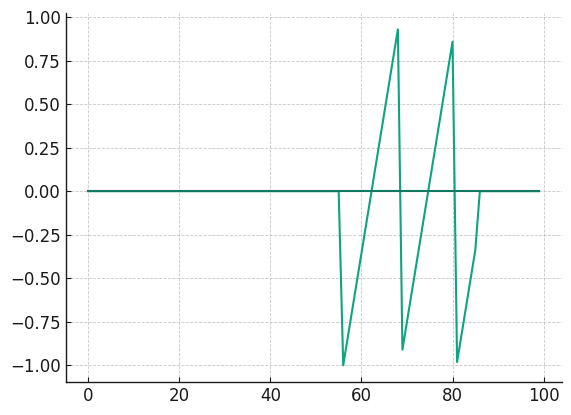

Label: 1


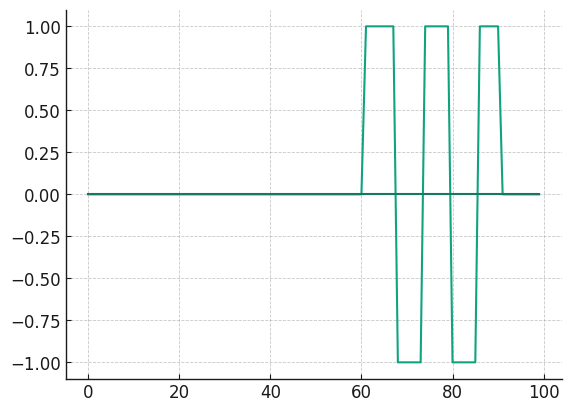

Label: 1


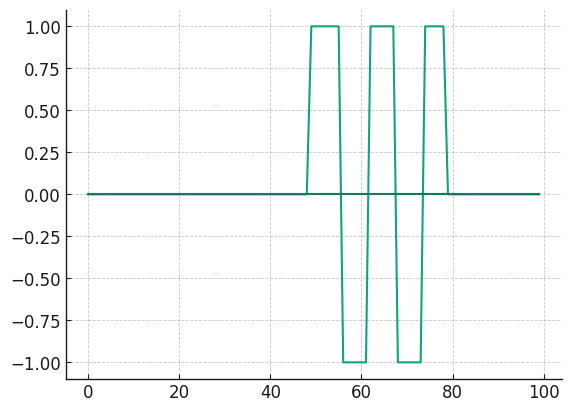

Label: 1


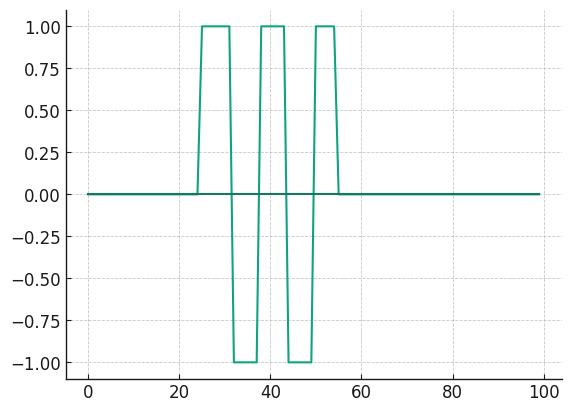

Label: 1


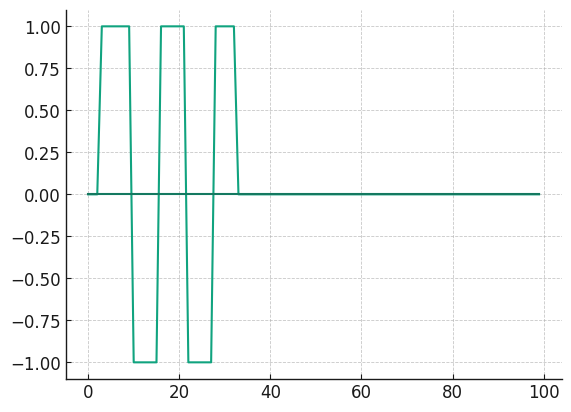

Label: 0


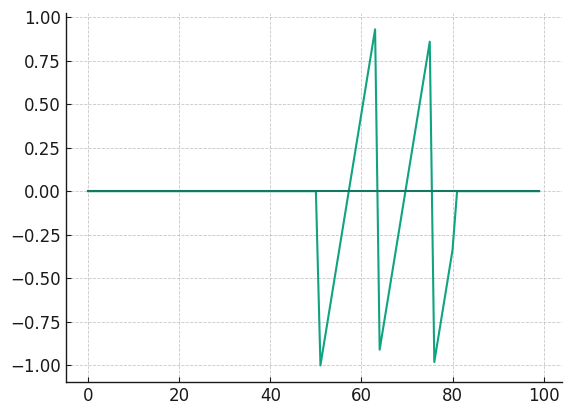

Label: 1


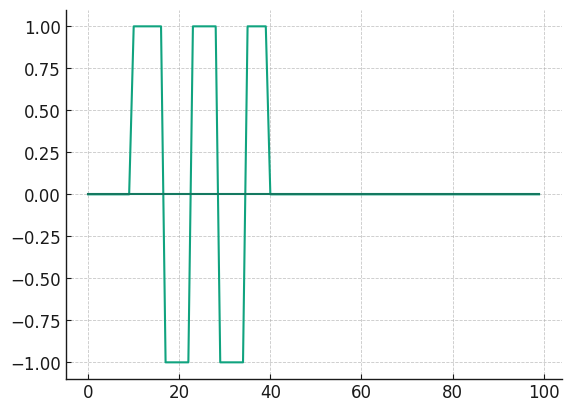

Label: 1


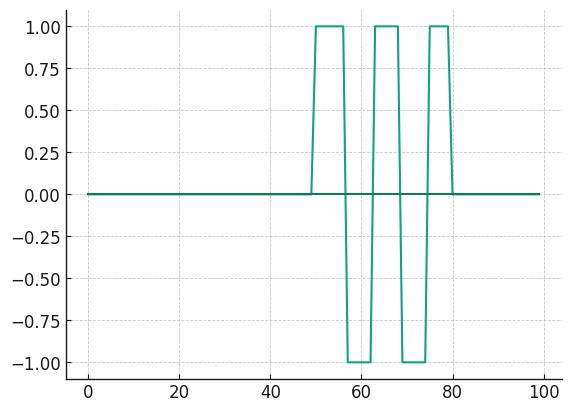

Label: 1


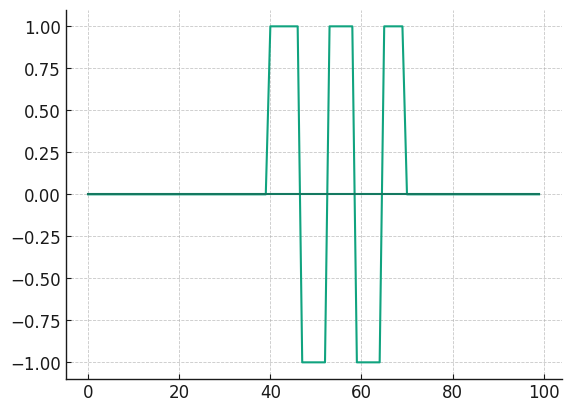

Label: 1


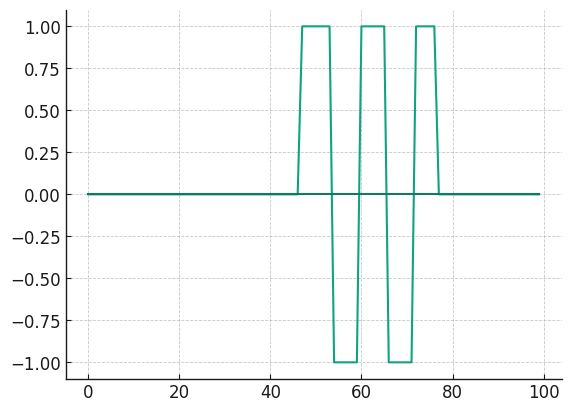

In [65]:
for i in range(10):
    idx = i
    print(f'Label: {dataset.get_label(idx)}')
    plt.plot(dataset[[idx]].T)
    plt.show()

In [87]:
test_dataset = ArtificialProtosDataset(50)
test_queries = ArtificialProtosQueries(test_dataset, "test")

In [88]:
test_queries.num_classes

2

In [71]:
idx = 6
print(f'Label: {test_dataset.get_label(idx)}')
print(f'Query 1: {test_queries.to_query(2*idx)}')
print(f'Query 2: {test_queries.to_query(2*idx + 1)}')

Label: 0
Query 1: (1.0::is_class(ts6,c0), {ts6: tensor(test(6))})
Query 2: (0.0::is_class(ts6,c1), {ts6: tensor(test(6))})


In [72]:
protos_per_class = 1
latent_features = 32

print('Preparing ProtoTSNet...')
autoencoder = RegularConvEncoder(num_features=3, latent_features=latent_features, padding='same')
encoder = autoencoder.encoder
net = ProtoTSNet(
    cnn_base=encoder,
    for_deepproblog=True,
    num_features=3,
    ts_sample_len=100,
    prototype_shape=(protos_per_class*2, latent_features, 20),
    num_classes=2,
    prototype_activation_function='log'
)

dpl_net = Network(net, "ptsnet", batching=False)
dpl_net.optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

print('Loading logic file...')
model = Model("proto_logic.pl", [dpl_net])
model.set_engine(ExactEngine(model))

Preparing ProtoTSNet...
Loading logic file...


In [77]:
model.load_state('./snapshots/initial_model.pth')
model.train()
model.eval()
model.add_tensor_source("test", test_dataset)

ProtoTSNet.eval()


In [74]:
next(net.parameters()).shape

torch.Size([2, 32, 20])

In [75]:
# idx = 7
# print(f'Label: {test_dataset.get_label(idx)}')
# plt.plot(test_dataset[[idx]][0])

In [79]:
idx = 3
print(f'Label: {test_dataset.get_label(idx)}')
print(model.solve([test_queries.to_query(2*idx+0)]))
print(model.solve([test_queries.to_query(2*idx+1)]))

Label: 1
[{is_class(tensor(test(3)),c0): tensor(0.0596, grad_fn=<SelectBackward0>)}]
[{is_class(tensor(test(3)),c1): tensor(0.9075, grad_fn=<SelectBackward0>)}]
